In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime
import statsmodels.api as sm
import numpy as np
from fredapi import Fred
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_score, StratifiedKFold, cross_validate
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler
fred = Fred(api_key='926acb260a284a87c73acdef0d2c2bd7')

## <span style = 'color:blue'> 1. Setting up Price data and market data

In [17]:
start_date = datetime(2016, 1, 1) 
end_date = datetime.now()
full_date_range = pd.date_range(start = start_date, end = end_date)

# Derive wmt price data
wmt = yf.download('WMT', start = start_date, end = end_date)
wmt.columns = wmt.columns.get_level_values(0)
wmt = wmt.reindex(full_date_range)

# Derive the US market data
market = yf.download('^GSPC', start = start_date, end = end_date)
market.columns = market.columns.get_level_values(0)
market = market.reindex(full_date_range)

print("wmt's data")
display(wmt)

print("market's data")
display(market)

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_19208\2678496962.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  wmt = yf.download('WMT', start = start_date, end = end_date)
[*********************100%***********************]  1 of 1 completed
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_19208\2678496962.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  market = yf.download('^GSPC', start = start_date, end = end_date)
[*********************100%***********************]  1 of 1 completed

wmt's data


Price,Close,High,Low,Open,Volume
2016-01-01,NaN,NaN,NaN,NaN,NaN
2016-01-02,NaN,NaN,NaN,NaN,NaN
2016-01-03,NaN,NaN,NaN,NaN,NaN
2016-01-04,17.109711,17.118063,16.803484,16.842459,35967600.0
2016-01-05,17.516159,17.552349,17.218284,17.268394,39978000.0
...,...,...,...,...,...
2025-11-21,105.320000,108.150002,104.720001,107.980003,41391700.0
2025-11-22,NaN,NaN,NaN,NaN,NaN
2025-11-23,NaN,NaN,NaN,NaN,NaN
2025-11-24,104.059998,106.269997,103.760002,105.360001,42487200.0


market's data


Price,Close,High,Low,Open,Volume
2016-01-01,NaN,NaN,NaN,NaN,NaN
2016-01-02,NaN,NaN,NaN,NaN,NaN
2016-01-03,NaN,NaN,NaN,NaN,NaN
2016-01-04,2012.660034,2038.199951,1989.680054,2038.199951,4.304880e+09
2016-01-05,2016.709961,2021.939941,2004.170044,2013.780029,3.706620e+09
...,...,...,...,...,...
2025-11-21,6602.990234,6660.049805,6521.919922,6555.770020,5.929930e+09
2025-11-22,NaN,NaN,NaN,NaN,NaN
2025-11-23,NaN,NaN,NaN,NaN,NaN
2025-11-24,6705.120117,6715.750000,6630.700195,6636.540039,6.039740e+09


## <span style = 'color:blue'> 2. Setting up Macroeconomic Data

In [18]:
types = ['Unemployment', 'GDP', 'Interest', 'Housing', 'CPI', 'PPI', ]
series_id = ['UNRATE', 'GDP','DFF', 'CSUSHPINSA', 'CPIAUCSL', 'PPIACO']

for (type, id) in zip(types, series_id):
    globals()[f'{type}'] = fred.get_series(id).to_frame()
    globals()[f'{type}'].rename(columns = {0: type}, inplace = True)
    print(globals()[f'{type}'].head(2))

            Unemployment
1948-01-01           3.4
1948-02-01           3.8
            GDP
1946-01-01  NaN
1946-04-01  NaN
            Interest
1954-07-01      1.13
1954-07-02      1.25
            Housing
1975-01-01      NaN
1975-02-01      NaN
              CPI
1947-01-01  21.48
1947-02-01  21.62
             PPI
1913-01-01  12.1
1913-02-01  12.0


### <span style = 'color:red'> Calculate the inflation rate and Reallign the dates

In [19]:
adj_start_date = datetime(2016, 4, 1)
CPI_inflation = CPI.pct_change(12) # Year-over-year change
print(CPI_inflation.dropna().head(2))
CPI_inflation = CPI_inflation.loc[start_date:]

PPI_inflation = PPI.pct_change(12) # Year-over-year change
print(PPI_inflation.dropna().head(2))
PPI_inflation = PPI_inflation.loc[start_date:]

GDP_growth = GDP.pct_change(1) # Calculate quarterly growth rates
GDP_growth = (1 + GDP_growth)**(4)-1 # Annualize the growth rates 
print(GDP_growth.dropna().head(2))
GDP_growth =GDP_growth.loc[start_date:]

Interest = Interest.loc[adj_start_date:]
Unrate = Unemployment.loc[adj_start_date:]

                 CPI
1948-01-01  0.102421
1948-02-01  0.094820
                 PPI
1914-01-01 -0.024793
1914-02-01 -0.016667
                 GDP
1947-04-01  0.046929
1947-07-01  0.060131


## <span style = 'color:blue'> 3. Setting up Financial Data

Text(0, 0.5, 'Close price ($)')

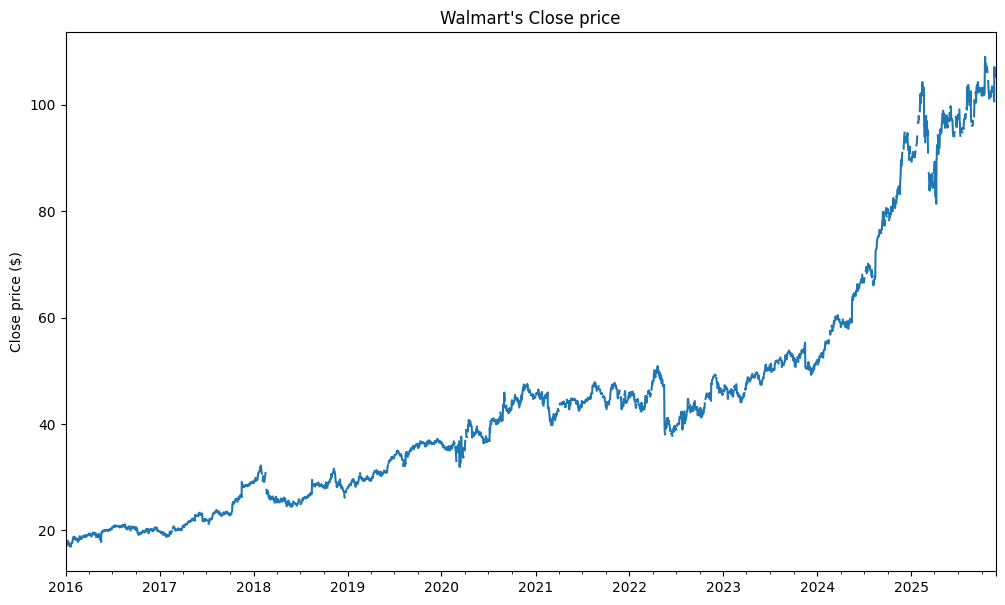

In [20]:
fig, ax = plt.subplots(1, 1, figsize = (12, 7))
wmt.Close.plot(ax = ax)
ax.set_title("Walmart's Close price")
ax.set_xlabel('')
ax.set_ylabel('Close price ($)')

In [21]:
# Get the EPS
income = pd.read_excel("Income Statement.xlsx", index_col=0)
eps = income.loc['Diluted EPS, GAAP', :]
eps = eps.to_frame()
eps.columns = ['Diluted EPS']

# Load in calculated ratios
ratios = pd.read_excel("Ratios.xlsx", index_col=0)
for col in ratios.columns:
    col_name = col.split()
    col_name = '_'.join(col_name)
    col_name = col_name.lower()
    globals()[f'{col_name}'] = ratios[col]

## <span style = 'color:blue'>4. Merge the data

In [22]:
# Readjust the start date so that the price data only includes non-null values
adj_start_date = datetime(2016, 4, 1)
df = pd.DataFrame({'Walmart': wmt['Close'],
                   'S&P500': market['Close'],
                   'Volume': wmt['Volume']})
merge_data = [GDP_growth, CPI_inflation, PPI_inflation, Interest, net_income_margin, eps, current_ratio, cash_conversion_cycle, debt_to_equity, Unrate]
for data in merge_data:
    df = df.merge(data, how = 'left', left_index = True, right_index = True)

df = df.ffill()
df = df.loc[adj_start_date:]
display(df)

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_19208\3679604247.py:10: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.ffill()


,Walmart,S&P500,Volume,GDP,CPI,PPI,Interest,Net Income Margin,Diluted EPS,Current Ratio,Cash Conversion Cycle,Debt to Equity,Unemployment
2016-04-01,19.367783,2072.780029,19807200.0,0.040717,0.011726,-0.040335,0.37,3.53,NaN,0.9322,11.0492,0.554831,5.1
2016-04-02,19.367783,2072.780029,19807200.0,0.040717,0.011726,-0.040335,0.37,3.53,NaN,0.9322,11.0492,0.554831,5.1
2016-04-03,19.367783,2072.780029,19807200.0,0.040717,0.011726,-0.040335,0.37,3.53,NaN,0.9322,11.0492,0.554831,5.1
2016-04-04,19.379004,2066.129883,20470200.0,0.040717,0.011726,-0.040335,0.37,3.53,NaN,0.9322,11.0492,0.554831,5.1
2016-04-05,19.249998,2045.170044,17337000.0,0.040717,0.011726,-0.040335,0.37,3.53,NaN,0.9322,11.0492,0.554831,5.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-21,105.320000,6602.990234,41391700.0,0.060387,0.030227,0.027323,3.88,3.96,0.88,0.7921,3.9990,0.671237,4.4
2025-11-22,105.320000,6602.990234,41391700.0,0.060387,0.030227,0.027323,3.88,3.96,0.88,0.7921,3.9990,0.671237,4.4
2025-11-23,105.320000,6602.990234,41391700.0,0.060387,0.030227,0.027323,3.88,3.96,0.88,0.7921,3.9990,0.671237,4.4
2025-11-24,104.059998,6705.120117,42487200.0,0.060387,0.030227,0.027323,3.88,3.96,0.88,0.7921,3.9990,0.671237,4.4


## <span style = 'color:blue'>5. Manually Filter out uneeded Variables

# Fundamental Analysis Ratios



| Category | Ratio Selected | Formula | Purpose |
|----------|----------------|---------|----------|
| **Solvency Ratio** | Debt to Equity | $$\text{Debt to Equity} = \frac{\text{Total Debt}}{\text{Shareholders' Equity}}$$ | Measures long-term financial leverage and risk|
| **Activity Ratio** | Cash Conversion Cycle (CCC) | $$\text{CCC} = \text{DIO} + \text{DSO} - \text{DPO}$$ | Measures time to convert inventory investment back into cash |
| **Liquidity Ratio** | Current Ratio | $$\text{Current Ratio} = \frac{\text{Current Assets}}{\text{Current Liabilities}}$$ | Measures short-term solvency (ability to meet short-term obligations) |
| **Profitability Ratio** | Net Income Margin | $$\text{Net Margin} = \frac{\text{Net Income}}{\text{Revenue}} \times 100\%$$ | Shows overall profitability after all expenses |


In [23]:
# Columns to keep
relevant_columns = ["GDP","CPI","Interest","Net Income Margin","Diluted EPS","Walmart","S&P500", 'Current Ratio', 'Cash Conversion Cycle', 'Debt to Equity', 'Volume', 'Unemployment']
df = df[relevant_columns]
df

,GDP,CPI,Interest,Net Income Margin,Diluted EPS,Walmart,S&P500,Current Ratio,Cash Conversion Cycle,Debt to Equity,Volume,Unemployment
2016-04-01,0.040717,0.011726,0.37,3.53,NaN,19.367783,2072.780029,0.9322,11.0492,0.554831,19807200.0,5.1
2016-04-02,0.040717,0.011726,0.37,3.53,NaN,19.367783,2072.780029,0.9322,11.0492,0.554831,19807200.0,5.1
2016-04-03,0.040717,0.011726,0.37,3.53,NaN,19.367783,2072.780029,0.9322,11.0492,0.554831,19807200.0,5.1
2016-04-04,0.040717,0.011726,0.37,3.53,NaN,19.379004,2066.129883,0.9322,11.0492,0.554831,20470200.0,5.1
2016-04-05,0.040717,0.011726,0.37,3.53,NaN,19.249998,2045.170044,0.9322,11.0492,0.554831,17337000.0,5.1
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-21,0.060387,0.030227,3.88,3.96,0.88,105.320000,6602.990234,0.7921,3.9990,0.671237,41391700.0,4.4
2025-11-22,0.060387,0.030227,3.88,3.96,0.88,105.320000,6602.990234,0.7921,3.9990,0.671237,41391700.0,4.4
2025-11-23,0.060387,0.030227,3.88,3.96,0.88,105.320000,6602.990234,0.7921,3.9990,0.671237,41391700.0,4.4
2025-11-24,0.060387,0.030227,3.88,3.96,0.88,104.059998,6705.120117,0.7921,3.9990,0.671237,42487200.0,4.4


## <span style = 'color:blue'>6. Calculate the technical indicators

In [24]:
import talib

df['MA30'] = talib.MA(df['Walmart'], 30)
df['MA7'] = talib.MA(df['Walmart'], 7)
# Trend Indicators (complementary to MA)
df['RSI'] = talib.RSI(df['Walmart'], timeperiod=14)  # Momentum oscillator
df['ADX'] = talib.ADX(df['Walmart'], df['Walmart'], df['Walmart'], timeperiod=14)  # Trend strength

# Volatility Indicator
df['ATR'] = talib.ATR(df['Walmart'], df['Walmart'], df['Walmart'], timeperiod=14)  # Average True Range

# Volume-based Indicator (if you have volume data)
df['OBV'] = talib.OBV(df['Walmart'], df['Volume'])  # On Balance Volume

lagged_df = df.drop(['Walmart', 'S&P500'], axis = 1).shift(1)
lagged_df['Walmart'] = df['Walmart']
lagged_df['S&P500'] = df['S&P500']
lagged_df.to_csv("final_data.csv")
display(lagged_df)

,GDP,CPI,Interest,Net Income Margin,Diluted EPS,Current Ratio,Cash Conversion Cycle,Debt to Equity,Volume,Unemployment,MA30,MA7,RSI,ADX,ATR,OBV,Walmart,S&P500
2016-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.367783,2072.780029
2016-04-02,0.040717,0.011726,0.37,3.53,NaN,0.9322,11.0492,0.554831,19807200.0,5.1,NaN,NaN,NaN,NaN,NaN,1.980720e+07,19.367783,2072.780029
2016-04-03,0.040717,0.011726,0.37,3.53,NaN,0.9322,11.0492,0.554831,19807200.0,5.1,NaN,NaN,NaN,NaN,NaN,1.980720e+07,19.367783,2072.780029
2016-04-04,0.040717,0.011726,0.37,3.53,NaN,0.9322,11.0492,0.554831,19807200.0,5.1,NaN,NaN,NaN,NaN,NaN,1.980720e+07,19.379004,2066.129883
2016-04-05,0.040717,0.011726,0.37,3.53,NaN,0.9322,11.0492,0.554831,20470200.0,5.1,NaN,NaN,NaN,NaN,NaN,4.027740e+07,19.249998,2045.170044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-21,0.060387,0.030227,3.88,3.96,0.88,0.7921,3.9990,0.671237,50375900.0,4.4,103.150000,102.785715,66.236972,16.657892,0.965509,2.345305e+09,105.320000,6602.990234
2025-11-22,0.060387,0.030227,3.88,3.96,0.88,0.7921,3.9990,0.671237,41391700.0,4.4,103.089333,103.191429,57.969827,16.606589,1.024401,2.303913e+09,105.320000,6602.990234
2025-11-23,0.060387,0.030227,3.88,3.96,0.88,0.7921,3.9990,0.671237,41391700.0,4.4,103.038000,103.597143,57.969827,16.558951,0.951230,2.303913e+09,105.320000,6602.990234
2025-11-24,0.060387,0.030227,3.88,3.96,0.88,0.7921,3.9990,0.671237,41391700.0,4.4,103.009666,104.002857,57.969827,16.514716,0.883285,2.303913e+09,104.059998,6705.120117
